In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# First Task

To estimate the average travel time from designated intersections to tollgates.

In [ ]:
import re
import pandas as pd
import numpy as np

In [ ]:
# Load dataset from csv files
data_train = pd.read_csv("/content/drive/My Drive/5002-Project/data/phase1_training/20min_avg_travel_time_training_phase1.csv")
data_test = pd.read_csv("/content/drive/My Drive/5002-Project/data/phase1_test/20min_avg_travel_time_test_phase1.csv")

|Attribute |Type| Description|
|----------|----|------------|
|intersection id |string |intersection ID|
|tollgate id |int |tollgate ID|
|time window |string |e.g., [2016-09-18 08:40:00, 2016-09-18 09:00:00]|
|avg travel time |float| average travel time (seconds)|


## 1.1 Preprocess data

We can see all the data was from the year of 2016. The training data was from `July 19th` to `October 17th` with 25,144 data and the testing data was from `October 18th` to `October 24th` with 448 data. One of the difficulty is how to handle the time windows.

I think the average travel time had no relationship with years, months and days, only related with the 20-min interval of time in 24 hours. The date form is `yyyy-mm-dd hh-mm-ss` and all the seconds are zero. Therefore, I divided a days by 72 intervals by 20 minutes and change the date into an integer in the interval of `[0, 71]`.

In [ ]:
def transform_date(pat, date):
    date = pat.findall(date)
    interval_from = int(date[0][0])*3 + int(date[0][1]) / 20
    interval_to = int(date[1][0])*3 + int(date[1][1]) / 20
    
    return [interval_from, interval_to]

In [ ]:
def preprocess(data, split_val=True, type="time"):

    # preprocess avg_travel_time dataset
    if type == "time":
        # Transfer intersection_id to integer
        data.loc[data.intersection_id == 'A',"intersection_id"] = 1.0
        data.loc[data.intersection_id == 'B',"intersection_id"] = 2.0
        data.loc[data.intersection_id == 'C',"intersection_id"] = 3.0
    
        # Transfer time_windows to interval_from and interval_to
        pat = re.compile(r'(\d{2}):(\d{2})')
        data["interval_from"] = data["time_window"].apply(lambda x: transform_date(pat, x)[0])
        data["interval_to"] = data["time_window"].apply(lambda x: transform_date(pat, x)[1])
        data.drop(["time_window"], axis=1, inplace=True)

        # split validation set
        if split_val == True:
            
            # divide routes by intersection_id and tollgate_id
            # have 6 routes totally
            df12 = data[(data.intersection_id == 1) & (data.tollgate_id == 2)].reset_index(drop=True)
            df13 = data[(data.intersection_id == 1) & (data.tollgate_id == 3)].reset_index(drop=True)

            df21 = data[(data.intersection_id == 2) & (data.tollgate_id == 1)].reset_index(drop=True)
            df23 = data[(data.intersection_id == 2) & (data.tollgate_id == 3)].reset_index(drop=True)

            df31 = data[(data.intersection_id == 3) & (data.tollgate_id == 1)].reset_index(drop=True)
            df33 = data[(data.intersection_id == 3) & (data.tollgate_id == 3)].reset_index(drop=True)

            # 2/8 sampling
            train_set = pd.concat([
                df12[:int(df12.shape[0]*0.8)], \
                df13[:int(df13.shape[0]*0.8)], \
                df21[:int(df21.shape[0]*0.8)], \
                df23[:int(df23.shape[0]*0.8)], \
                df31[:int(df31.shape[0]*0.8)], \
                df33[:int(df33.shape[0]*0.8)]
            ]).reset_index(drop=True)

            val_set = pd.concat([
                df12[int(df12.shape[0]*0.8):], \
                df13[int(df13.shape[0]*0.8):], \
                df21[int(df21.shape[0]*0.8):], \
                df23[int(df23.shape[0]*0.8):], \
                df31[int(df31.shape[0]*0.8):], \
                df33[int(df33.shape[0]*0.8):]
            ]).reset_index(drop=True)

            print("number of training data = %s" % train_set.shape[0])
            print("number of validation data = %s" % val_set.shape[0])
    
            X_train = train_set[["intersection_id", "tollgate_id", "interval_from", "interval_to"]]
            y_train = train_set["avg_travel_time"]
            X_val = val_set[["intersection_id", "tollgate_id", "interval_from", "interval_to"]]
            y_val = val_set["avg_travel_time"]
    
            return X_train, y_train, X_val, y_val

        # not split validation set
        else:
            X = data[["intersection_id", "tollgate_id", "interval_from", "interval_to"]]
            y = data["avg_travel_time"]
            print("number of data = %s" % data.shape[0])
            return X, y

    # preprocess avg_volume dataset
    if type == "volume":
        # Transfer time_windows to interval_from and interval_to
        pat = re.compile(r'(\d{2}):(\d{2})')
        data["interval_from"] = data["time_window"].apply(lambda x: transform_date(pat, x)[0])
        data["interval_to"] = data["time_window"].apply(lambda x: transform_date(pat, x)[1])
        data.drop(["time_window"], axis=1, inplace=True)

        # split validation set
        if split_val == True:

            # divide pairs by tollgate_id and direction
            # have 6 tollgate-direction pairs totally
            df10 = data[(data.tollgate_id == 1) & (data.direction == 0)].reset_index(drop=True)
            df11 = data[(data.tollgate_id == 1) & (data.direction == 1)].reset_index(drop=True)

            df20 = data[(data.tollgate_id == 2) & (data.direction == 0)].reset_index(drop=True)
            df21 = data[(data.tollgate_id == 2) & (data.direction == 1)].reset_index(drop=True)

            df30 = data[(data.tollgate_id == 3) & (data.direction == 0)].reset_index(drop=True)
            df31 = data[(data.tollgate_id == 3) & (data.direction == 1)].reset_index(drop=True)

            # 2/8 sampling
            train_set = pd.concat([
                df10[:int(df10.shape[0]*0.8)], \
                df11[:int(df11.shape[0]*0.8)], \
                df20[:int(df20.shape[0]*0.8)], \
                df21[:int(df21.shape[0]*0.8)], \
                df30[:int(df30.shape[0]*0.8)], \
                df31[:int(df31.shape[0]*0.8)]
            ]).reset_index(drop=True)

            val_set = pd.concat([
                df10[int(df10.shape[0]*0.8):], \
                df11[int(df11.shape[0]*0.8):], \
                df20[int(df20.shape[0]*0.8):], \
                df21[int(df21.shape[0]*0.8):], \
                df30[int(df30.shape[0]*0.8):], \
                df31[int(df31.shape[0]*0.8):]
            ]).reset_index(drop=True)

            print("number of training data = %s" % train_set.shape[0])
            print("number of validation data = %s" % val_set.shape[0])
    
            X_train = train_set[["tollgate_id", "direction", "interval_from", "interval_to"]]
            y_train = train_set["volume"]
            X_val = val_set[["tollgate_id", "direction", "interval_from", "interval_to"]]
            y_val = val_set["volume"]
    
            return X_train, y_train, X_val, y_val

        # not split validation set
        else:
            X = data[["tollgate_id", "direction", "interval_from", "interval_to"]]
            y = data["volume"]
            print("number of data = %s" % data.shape[0])
            return X, y

In [53]:
X_train, y_train, X_val, y_val = preprocess(data_train, split_val=True, type="time")

number of training data = 20113
number of validation data = 5031


## 1.2 Train and Tune Parameters

Train the model on training set and tune parameters on validation set. I'll try two different model: 

1. Random Forest Regression 
2. Feedforward Neural Network

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import torch

In [ ]:
def evaluate_MAPE(X, y, y_pred, type="time"):

    df = pd.concat([X, y, y_pred], axis=1)

    if type == "time":
        df.rename(columns={0: "pred_time"}, inplace=True)
        df["ratio"] = ((df["avg_travel_time"] - df["pred_time"]) / df["avg_travel_time"]).abs()
        groups = df.groupby(["intersection_id", "tollgate_id"]).mean()
        MAPE = groups["ratio"].sum() / groups.shape[0]

    if type == "volume":
        df.rename(columns={0: "pred_volume"}, inplace=True)
        df["ratio"] = ((df["volume"] - df["pred_volume"]) / df["volume"]).abs()
        groups = df.groupby(["tollgate_id", "direction"]).mean()
        MAPE = groups["ratio"].sum() / groups.shape[0]
    
    return MAPE

processing: 10/100
processing: 20/100
processing: 30/100
processing: 40/100
processing: 50/100
processing: 60/100
processing: 70/100
processing: 80/100
processing: 90/100
lowest MAPE = 0.2523890713474992
best n_estimators = 99


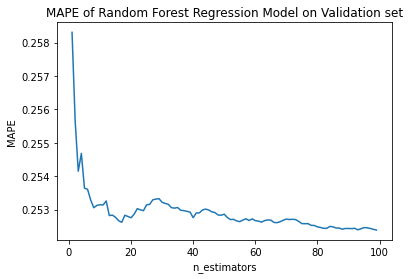

In [54]:
# Random Forest Regression
MAPE = []
lowest_MAPE = 1
best_n = 1
best_RF_model = None
for n in range(1,100):
    regr_RF = RandomForestRegressor(n_estimators=n, random_state=0)
    regr_RF.fit(X_train, y_train)
    y_pred = pd.DataFrame(regr_RF.predict(X_val))
    MAPE_n = evaluate_MAPE(X_val, y_val, y_pred, type="time")
    MAPE.append(MAPE_n)

    if MAPE_n < lowest_MAPE:
        lowest_MAPE = MAPE_n
        best_RF_model = regr_RF
        best_n = n
    
    if n%10 == 0:
        print("processing: %s/%s" % (n, 100))

print("lowest MAPE = %s" % lowest_MAPE)
print("best n_estimators = %s" % best_n)

plt.title("MAPE of Random Forest Regression Model on Validation set")
plt.xlabel("n_estimators")
plt.ylabel("MAPE")
plt.plot(range(1,100), MAPE)
plt.show()

In [10]:
# Test cuda if works
torch.cuda.is_available()

True

In [ ]:
device = torch.device('cuda')

In [ ]:
# Use Pytroch to build a Feedforward Neural Network
class FNN:
    
    def __init__(self, D_in, H1, H2, D_out, iteration, lr, device):
        self.D_in = D_in
        self.H1 = H1
        self.H2 = H2
        self.D_out = D_out
        self.iteration = iteration
        self.lr = lr
        self.device = device
    
    def evaluate_MAPE(self, X, y, y_pred):
      X = pd.DataFrame(X.cpu().numpy())
      y = pd.DataFrame(y.cpu().numpy())
      y_pred = pd.DataFrame(y_pred.cpu().detach().numpy())
      df = pd.concat([X, y, y_pred], axis=1, ignore_index=True)
      df["ratio"] = ((df[4] - df[5]) / df[4]).abs()
      groups = df.groupby([0, 1]).mean()
      MAPE = groups["ratio"].sum() / groups.shape[0]
      return MAPE

    def train(self, X_train, y_train, X_val, y_val):
        model = torch.nn.Sequential(
                    torch.nn.Linear(self.D_in, self.H1),
                    torch.nn.ReLU(),
                    torch.nn.Linear(self.H1, self.H2),
                    torch.nn.ReLU(),
                    torch.nn.Linear(self.H2, self.D_out)
                ).to(self.device)

        loss_list = []
        MAPE = []
        lowest_MAPE = 1.0
        best_model = None
    
        # Loss function
        loss_fn = torch.nn.MSELoss(reduction='mean')      

        # SGD optimizer
        optimizer = torch.optim.SGD(model.parameters(), lr=self.lr)

        for t in range(self.iteration):
            
            if t%100 == 0:
                print("iteration: %s/%s" % (t, self.iteration))
                
            y_train_pred = model(X_train).squeeze()
            loss = loss_fn(y_train_pred, y_train)
            loss_list.append(loss.item())
            
            y_val_pred = model(X_val).squeeze()
            MAPE_t = self.evaluate_MAPE(X_val, y_val, y_val_pred)
            MAPE.append(MAPE_t)
            
            if MAPE_t < lowest_MAPE:
                lowest_MAPE = MAPE_t
                best_model = model
            
            # zero gradient
            optimizer.zero_grad()
        
            # Backward pass
            loss.backward()
            
            # Update parameters
            optimizer.step()
        
        self.loss_ = loss_list
        self.MAPE_ = MAPE
        self.lowest_MAPE_ = lowest_MAPE
        self.best_model_ = best_model
    
    def predict(self, X):

        return self.best_model_(X)

    def visualize(self):
        # Loss curve
        fig = plt.figure(figsize=(15,4))
        ax1 = plt.subplot(1,2,1)
        ax2 = plt.subplot(1,2,2)
        plt.sca(ax1)
        plt.title("The Loss on training set")
        plt.xlabel("iteration")
        plt.ylabel("loss")
        plt.plot(range(self.iteration), self.loss_)
        # MAPE on validation set
        plt.sca(ax2)
        plt.title("The MAPE on validation set")
        plt.xlabel("iteration")
        plt.ylabel("MAPE")
        plt.plot(range(self.iteration), self.MAPE_)

        plt.show()

In [ ]:
# Transfer dataframe to tensor
X_train_tensor = torch.from_numpy(X_train.to_numpy().astype(np.float32)).cuda()
y_train_tensor = torch.from_numpy(y_train.to_numpy().astype(np.float32)).cuda()
X_val_tensor = torch.from_numpy(X_val.to_numpy().astype(np.float32)).cuda()
y_val_tensor = torch.from_numpy(y_val.to_numpy().astype(np.float32)).cuda()

iteration: 0/500
iteration: 100/500
iteration: 200/500
iteration: 300/500
iteration: 400/500
lowest MAPE = 0.4791315793991089


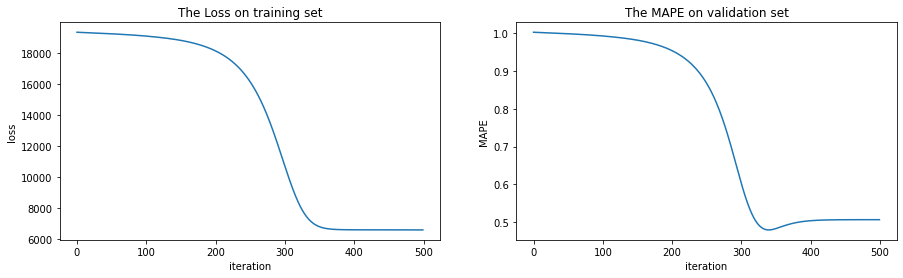

In [30]:
# Initialize Neural Network
fnn = FNN(D_in=4, H1=3, H2=3, D_out=1, iteration=500, lr=1e-6, device=device)
# Train network
fnn.train(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

# Print lowest MAPE
print("lowest MAPE = %s" % fnn.lowest_MAPE_)

# Plot the loss curve and MAPE on validation set
fnn.visualize()

## 1.3 Predict on testing dataset

In [16]:
X_test, y_test = preprocess(data_test, split_val=False, type="time") # y_test is NaN

number of data = 448


In [ ]:
# Use best RF model to predict on testing dataset
y_test = best_RF_model.predict(X_test)

In [ ]:
y_test

In [ ]:
# Use NN model to predict
X_test_tensor = torch.from_numpy(X_test.to_numpy().astype(np.float32)).cuda()
y_test_tensor = fnn.predict(X_test_tensor)

In [ ]:
y_test_tensor

# Another Task

Another task is to predict average tollgate traffic volume. The dataset structure has highly similarity of the previous task so we can reuse some functions in last task.

|Attribute |Type| Description|
|----------|----|------------|
|tollgate id |int| tollgate |ID|
|time window | string | e.g., [2016-09-18 08:40:00, 2016-09-18 09:00:00]|
|direction |string |0:entry, 1: exit|
|volume | int | total volume |

In [43]:
# Load dataset from csv files and preprocess
data_train = pd.read_csv("/content/drive/My Drive/5002-Project/data/phase1_training/20min_avg_volume_training_phase1.csv")
data_test = pd.read_csv("/content/drive/My Drive/5002-Project/data/phase1_test/20min_avg_volume_test_phase1.csv")

X_train, y_train, X_val, y_val = preprocess(data_train, split_val=True, type="volume")
X_test, y_test = preprocess(data_test, split_val=False, type="volume")

number of training data = 8049
number of validation data = 2014
number of data = 420


processing: 10/100
processing: 20/100
processing: 30/100
processing: 40/100
processing: 50/100
processing: 60/100
processing: 70/100
processing: 80/100
processing: 90/100
lowest MAPE = 0.44467086147059864
best n_estimators = 3


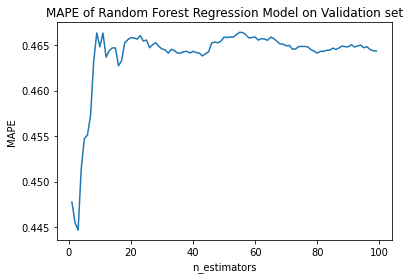

In [47]:
# Random Forest Regression
MAPE = []
lowest_MAPE = 1
best_n = 1
best_RF_model = None
for n in range(1,100):
    regr_RF = RandomForestRegressor(n_estimators=n, random_state=0)
    regr_RF.fit(X_train, y_train)
    y_pred = pd.DataFrame(regr_RF.predict(X_val))
    MAPE_n = evaluate_MAPE(X_val, y_val, y_pred, type="volume")
    MAPE.append(MAPE_n)

    if MAPE_n < lowest_MAPE:
        lowest_MAPE = MAPE_n
        best_RF_model = regr_RF
        best_n = n
    
    if n%10 == 0:
        print("processing: %s/%s" % (n, 100))

print("lowest MAPE = %s" % lowest_MAPE)
print("best n_estimators = %s" % best_n)

plt.title("MAPE of Random Forest Regression Model on Validation set")
plt.xlabel("n_estimators")
plt.ylabel("MAPE")
plt.plot(range(1,100), MAPE)
plt.show()

In [ ]:
# Transfer dataframe to tensor
X_train_tensor = torch.from_numpy(X_train.to_numpy().astype(np.float32)).cuda()
y_train_tensor = torch.from_numpy(y_train.to_numpy().astype(np.float32)).cuda()
X_val_tensor = torch.from_numpy(X_val.to_numpy().astype(np.float32)).cuda()
y_val_tensor = torch.from_numpy(y_val.to_numpy().astype(np.float32)).cuda()

iteration: 0/500
iteration: 100/500
iteration: 200/500
iteration: 300/500
iteration: 400/500
lowest MAPE = 0.7795748233795166


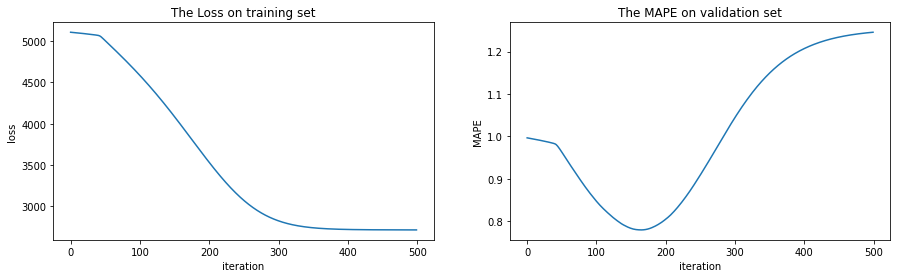

In [49]:
# Initialize Neural Network
fnn = FNN(D_in=4, H1=3, H2=3, D_out=1, iteration=500, lr=1e-6, device=device)
# Train network
fnn.train(X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor)

# Print lowest MAPE
print("lowest MAPE = %s" % fnn.lowest_MAPE_)

# Plot the loss curve and MAPE on validation set
fnn.visualize()

In [ ]:
X_test, y_test = preprocess(data_test, split_val=False, type="time")

# Use best RF model to predict on testing dataset
y_test = best_RF_model.predict(X_test)

In [ ]:
# Use NN model to predict
X_test_tensor = torch.from_numpy(X_test.to_numpy().astype(np.float32)).cuda()
y_test_tensor = fnn.predict(X_test_tensor)